This example is for training a Noise2Void denoising model using RGB images. Images need to be in lossless format (e.g., png or tiff). JPG format is not allowed if you're using the DataGenerator object but you can use skimage or other ibraries to load them. The same approach can be used for grey-scale images, for example SEM or CT images.

In [2]:
!pip install n2v

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 24.0 MB/s eta 0:00:00


In [3]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context



Training Data Preparation

For training we can load a bunch of noisy images from a directory. Images can be of different sizes as we will be capturing them as a list, not an array. Of course, each image is an array. We will use the N2V_DataGenerator to extract training X and validation X_val patches.

In [4]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()



If you have many images stored in a directory, use load_imgs_from_directory method to load them into a list. Images can be of different sizes as we are capturing them into a list, not an array.

You can also use your favorite way of reading images (e.g., using skimage) sequentially and capturing them into a list that can be used as input to the network.

Note that the images need to be in float32 format. load_imgs_from_directory method converts images to float32 but if you use your own way of loading images, you need to make sure they are converted to float32.

In [8]:
#METHOD 1: Loading images using load_imgs_from_directory method
# We load all the '.png' files from the directory.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "/content/drive/MyDrive/n2v/data",
                                        filter='sky*.png',dims='YXC')  #ZYX for 3D

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)

shape of loaded images:  (1, 521, 800, 3)
shape without alpha:     (1, 521, 800, 3)
The data type of the first image is:  float32


In [9]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

1
(1, 521, 800, 3)
float32


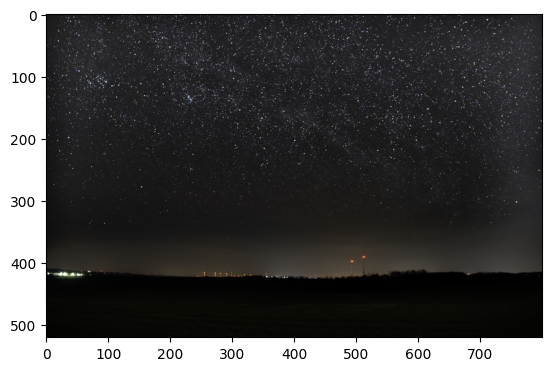

In [10]:
# Let's look at the image.
plt.figure()
plt.imshow(imgs[0][0,:,:,:])
plt.show()

In [11]:
patch_size = 64

In [12]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (768, 64, 64, 3)


In [13]:
patches.shape

(768, 64, 64, 3)

In [14]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [15]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(614, 64, 64, 3)
float32
(154, 64, 64, 3)


In [16]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

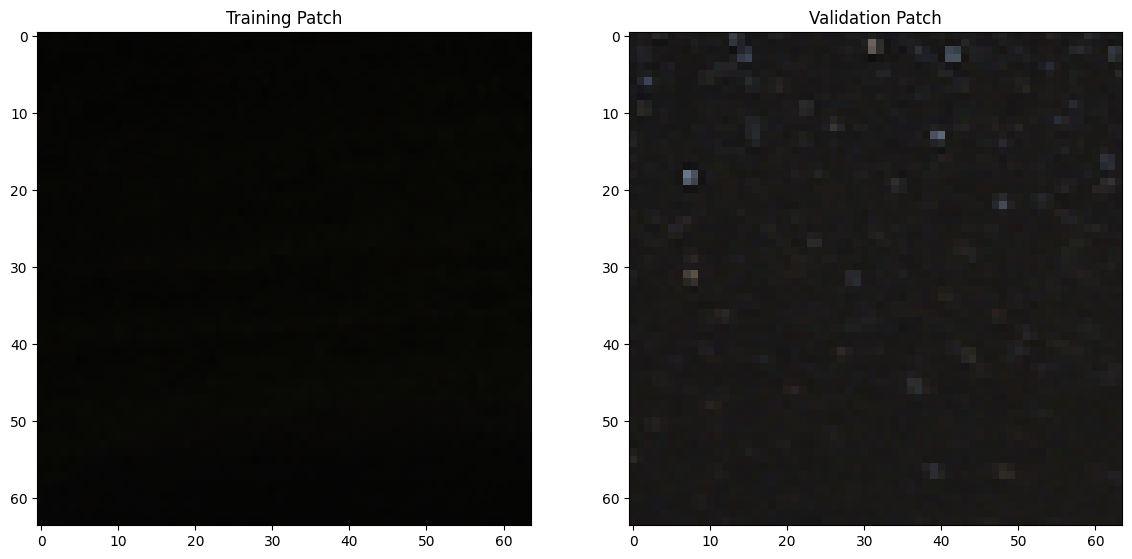

In [17]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');


**Configure**

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.

When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.

**Other pixel manipulators:**

* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation
For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

**Warning ** to make this example notebook execute faster, we have set train_epochs to only 10. For better results we suggest 100 to 200 train_epochs.

In [18]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.1220854', '0.118272215', '0.11913208'],
 'stds': ['0.073477134', '0.07248868', '0.07812209'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 19,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [20]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D_stars'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

**Training**

In [21]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 154/154 [00:00<00:00, 662.12it/s]


Epoch 1/20
19/19 [==============================] - 165s 8s/step - loss: 0.5365 - n2v_mse: 0.5365 - n2v_abs: 0.4764 - val_loss: 0.7411 - val_n2v_mse: 0.7432 - val_n2v_abs: 0.5283 - lr: 4.0000e-04
Epoch 2/20
19/19 [==============================] - 149s 8s/step - loss: 0.1649 - n2v_mse: 0.1649 - n2v_abs: 0.2578 - val_loss: 0.6842 - val_n2v_mse: 0.6875 - val_n2v_abs: 0.4904 - lr: 4.0000e-04
Epoch 3/20
19/19 [==============================] - 153s 8s/step - loss: 0.1132 - n2v_mse: 0.1132 - n2v_abs: 0.2237 - val_loss: 0.6511 - val_n2v_mse: 0.6553 - val_n2v_abs: 0.4719 - lr: 4.0000e-04
Epoch 4/20
19/19 [==============================] - 154s 8s/step - loss: 0.0955 - n2v_mse: 0.0955 - n2v_abs: 0.2054 - val_loss: 0.6190 - val_n2v_mse: 0.6231 - val_n2v_abs: 0.4584 - lr: 4.0000e-04
Epoch 5/20
19/19 [==============================] - 160s 9s/step - loss: 0.0916 - n2v_mse: 0.0916 - n2v_abs: 0.2011 - val_loss: 0.5963 - val_n2v_mse: 0.6002 - val_n2v_abs: 0.4458 - lr: 4.0000e-04
Epoch 6/20
19/19 [==

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


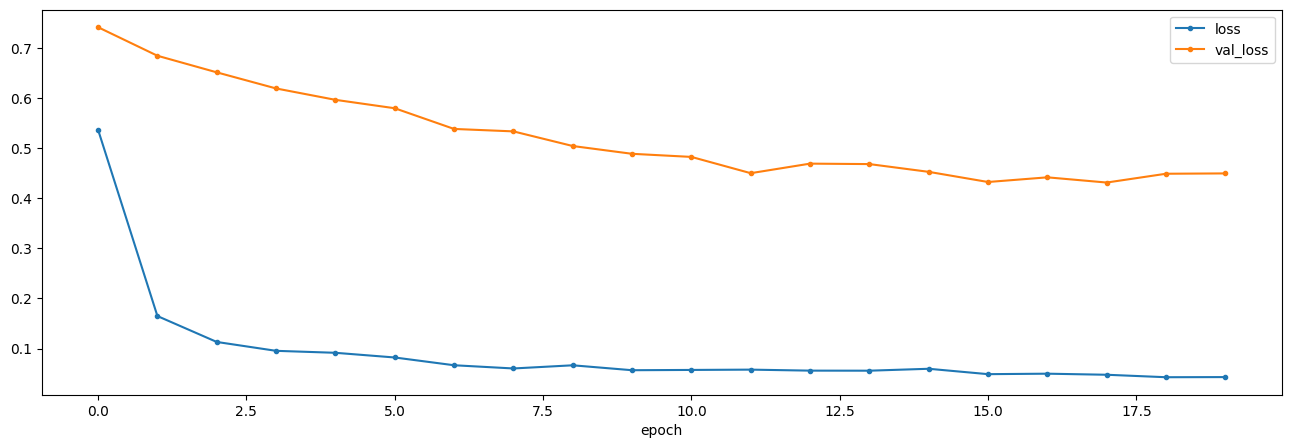

In [22]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);


Denoising images using the trained model

In [23]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [24]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


Denoising (prediction)

In [25]:
# We load the data we want to process.
img = imread('/content/drive/MyDrive/n2v/data/sky.png')
img.dtype

dtype('float32')

In [26]:
# Here we denoise the image (predict)
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred = model.predict(img, axes='YXC')

1/1 [==============================] - 8s 8s/step


In [27]:
pred.shape

(521, 800, 3)

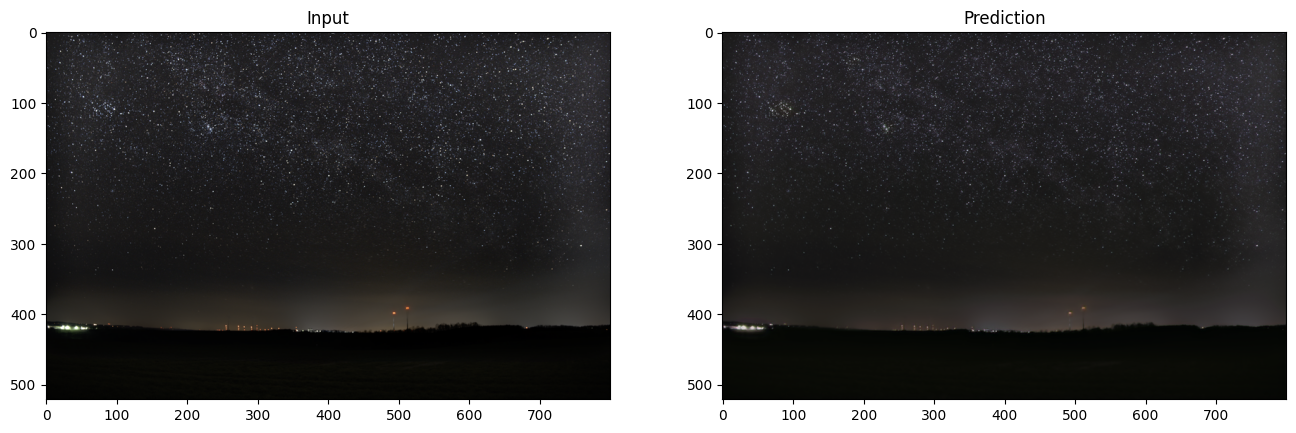

In [28]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');